In [1]:
import torch
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm 
import copy
import os
import matplotlib.pyplot as plt

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("kaggle_data/train.csv")

In [3]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [4]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [5]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [6]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0


### Create a Prediction File

In [10]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=716.4264615618442 median=600.0 std=684.7511617510816


In [11]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

Using: 1692771/1710670
0
1
2
3
4
5


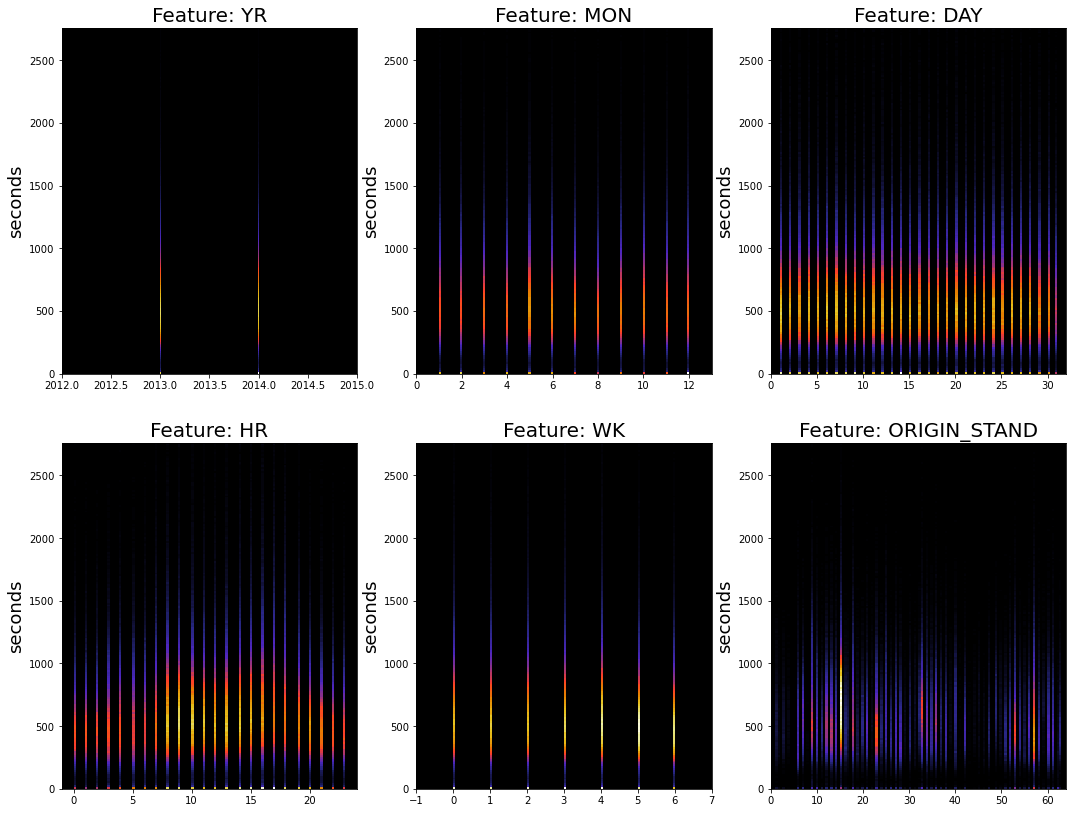

In [12]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
    print(idx)
    ax = axs[idx // 3, idx % 3]

    # Remove any rows with invalid values
    df_subset = df_trimmed.dropna(subset=v)

    # Create a histogram. Look up the documentation for more details
    ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))

    # Some stylistic things to make the graphs look nice
    ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
    ax.set_facecolor("black")
    ax.set_ylabel("seconds", fontsize=18)
    ax.set_title(f"Feature: {v}", fontsize=20)


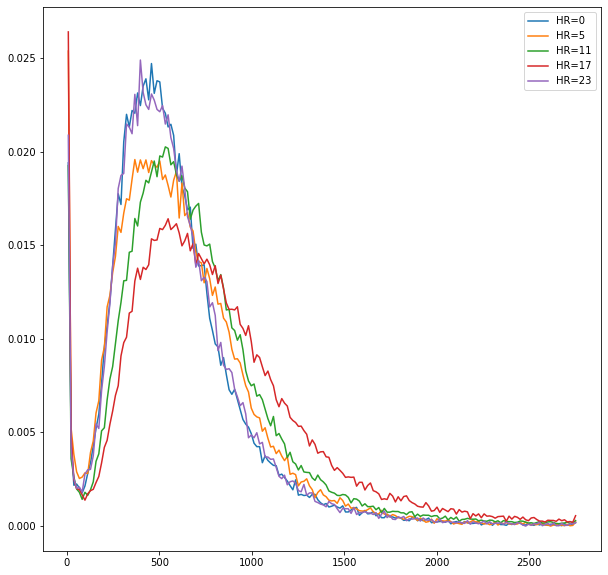

In [13]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
    # Filter data where the HR matches v
    hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

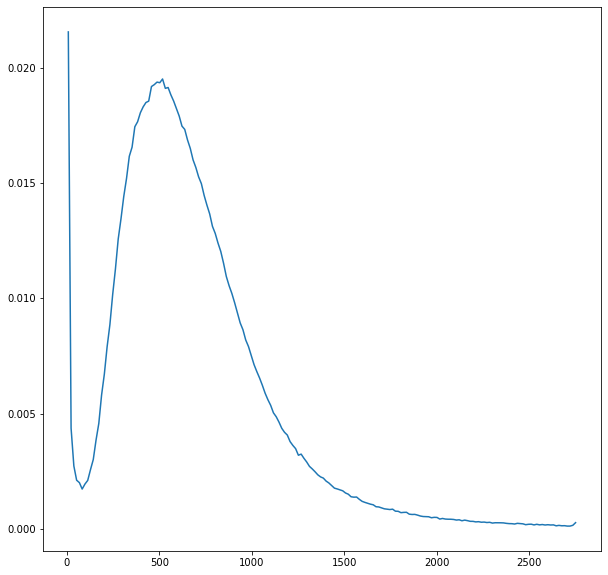

In [14]:
plt.figure(figsize=(10,10))
hourly_data = df_trimmed["LEN"]
bins=buckets
histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
histogram = histogram / len(hourly_data)
# The center is the left_bound and right_bound of a bucket
bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
plt.plot(bin_centers, histogram, label=f"CALL_TYPE={v}")

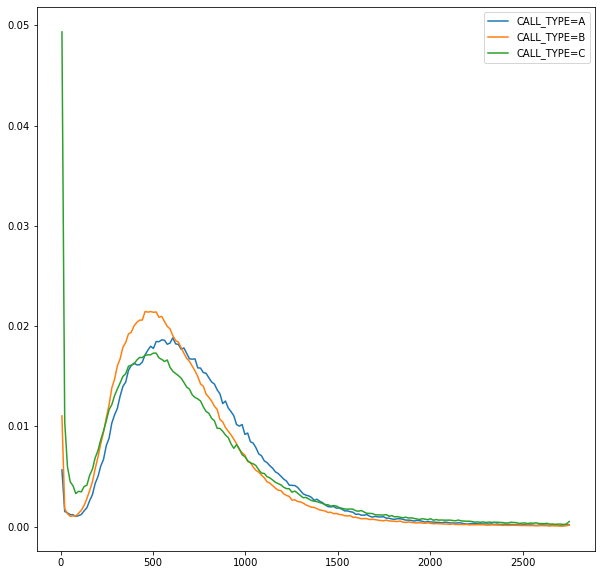

In [15]:
plt.figure(figsize=(10,10))
for v in ['A','B','C']:
    # Filter data where the HR matches v
    hourly_data = df_trimmed[df_trimmed["CALL_TYPE"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"CALL_TYPE={v}")
plt.legend();

In [16]:
df_filled = df_trimmed.fillna(0)

In [17]:
df_B = df_trimmed[df_trimmed['CALL_TYPE'] == 'B']

In [18]:
df_B_cl = df_B.dropna(subset=['ORIGIN_STAND'])

In [19]:
len(df_B_cl)

802961

In [20]:
stands = sorted(df_B_cl['ORIGIN_STAND'].unique())

In [21]:
len_stands = []
len_err = []
for i in stands:
    m = df_B_cl[df_B_cl['ORIGIN_STAND']==i]['LEN'].mean()
    s = df_B_cl[df_B_cl['ORIGIN_STAND']==i]['LEN'].std()
    len_stands.append(m)
    len_err.append(s)

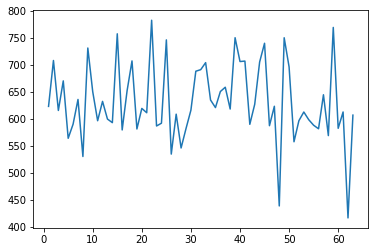

In [22]:
plt.plot(stands,len_stands)

<ErrorbarContainer object of 3 artists>

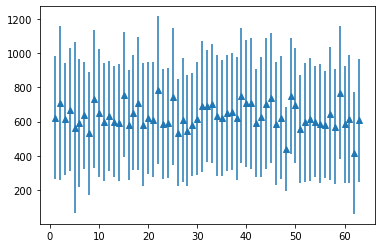

In [23]:
plt.errorbar(stands, len_stands, len_err, linestyle='None', marker='^')

In [24]:
ct = pd.get_dummies(df_trimmed['CALL_TYPE'])
ct.columns = ['ct_A','ct_B','ct_C']

In [207]:
stan = pd.get_dummies(df_trimmed['ORIGIN_STAND'].fillna(0))

In [215]:
cols = ['YR','MON','DAY','HR','WK','ct_A','ct_B','ct_C']+list(stan.columns)

In [221]:
df_feat = pd.concat([df_trimmed,ct,stan],axis=1)
df_feat['ORIGIN_STAND']=df_feat['ORIGIN_STAND'].fillna(0)
X = df_feat[cols].to_numpy().astype(float)
y = df_feat['LEN'].to_numpy().astype(float)

In [226]:
X.shape

(1692771, 72)

In [222]:
from sklearn.model_selection import train_test_split

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [224]:
device = torch.device('cuda')

In [225]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

In [282]:
model = nn.Sequential(
    nn.Linear(72, 144),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.BatchNorm1d(144),
    nn.Linear(144, 18),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.BatchNorm1d(18),
    nn.Linear(18, 1),
).to(device)

In [283]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [284]:
save = {'w':None,'history':[],'mse':np.inf}

In [285]:
n_epochs = 50   # number of epochs to run
batch_size = 128  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [286]:
best_mse = save['mse']  # init to infinity
best_weights = save['w']
history_train = save['history']
history_test = []

for epoch in range(n_epochs):
    model.train()
    bar = tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True)
    temp_his = []
    for start in bar:
        # take a batch
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch)
        a = y_pred.cpu().detach().numpy().transpose()[0]
        loss = loss_fn(y_pred, y_batch)
        temp_his.append(float(loss))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
        bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    history_train.append(np.mean(temp_his))
    model.eval()
    y_pred = model(X_test)
    a = y_pred.cpu().detach().numpy().transpose()[0]
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history_test.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

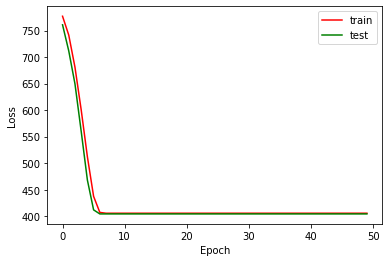

In [287]:
# Plotting both the curves simultaneously
plt.plot(np.sqrt(history_train), color='r', label='train')
plt.plot(np.sqrt(history_test), color='g', label='test')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [288]:
test = pd.read_csv('kaggle_data/test_public.csv')
tid =  test[['TRIP_ID']]
test[["YR", "MON", "DAY", "HR", "WK"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
ct_test = pd.get_dummies(test['CALL_TYPE'])
ct_test.columns = ['ct_A','ct_B','ct_C']
enc = OneHotEncoder()
enc.fit(np.array(df_trimmed[['ORIGIN_STAND']].fillna(0)))
stan_test = pd.DataFrame(enc.transform(np.array(test[['ORIGIN_STAND']].fillna(0))).toarray())
test = pd.concat([test,ct_test,stan_test],axis=1)
test = test[['YR','MON','DAY','HR','WK','ct_A','ct_B','ct_C']+list(stan_test.columns)].to_numpy().astype(float)
test = torch.tensor(test, dtype=torch.float32).to(device)

In [289]:
test

tensor([[2014.,    8.,   14.,  ...,    0.,    0.,    0.],
        [2014.,    8.,   14.,  ...,    0.,    0.,    0.],
        [2014.,    8.,   14.,  ...,    0.,    0.,    0.],
        ...,
        [2014.,   12.,   21.,  ...,    0.,    0.,    0.],
        [2014.,   12.,   21.,  ...,    0.,    0.,    0.],
        [2014.,   12.,   21.,  ...,    0.,    0.,    0.]], device='cuda:0')

In [237]:
from sklearn.preprocessing import OneHotEncoder

In [194]:
import math

In [290]:
pred = model(test).cpu().detach().numpy().transpose()[0]
tid['TRAVEL_TIME'] = pred
tid.to_csv('submission.csv',index=False)
tid

,TRIP_ID,TRAVEL_TIME
0,T1,671.106506
1,T2,671.106506
2,T3,671.106506
3,T4,671.106506
4,T5,671.106506
...,...,...
315,T323,671.106506
316,T324,671.106506
317,T325,671.106506
318,T326,671.106506


In [276]:
torch.save(best_weights, 'weight.pt')
#with open('history.txt', 'w') as f:
    #for line in history:
        #f.write("%s\n" % line)
#with open('best_mse.txt', 'w') as f:
    #f.write("%s\n" % save['mse'])